# Predict Airline Passengers using ARIMA Timeseries Analysis

This Kaggle dataset shows the count of airline passengers from 1949 till 1969. The goal is to predict the number of airline passengers for the next years.

### Table of contents
- clean and prepare data
- explore and visualize timeseries
- stationarizing timeseries
- find model parameters
- fit the model
- make predictions

In [1]:
#data processing
import pandas as pd
import numpy as np
import os
import datetime

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.ar_model import ar_select_order

#machine learning models
from statsmodels.tsa.arima_model import ARIMA

In [2]:
pwd = os.getcwd()
df = pd.read_csv(pwd + '/flights.csv', sep=",")
df.head()

,date,passengers
0,1949-01-01,64
1,1949-02-01,75
2,1949-03-01,98
3,1949-04-01,93
4,1949-05-01,80


## Clean and prepare data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        132 non-null    object
 1   passengers  132 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [4]:
#check for missing values
df.isnull().sum()

date          0
passengers    0
dtype: int64

In [5]:
#convert dtype and set date as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [6]:
# create new datetime features
df['year'] = df.index.year.astype(int)
df['month'] = df.index.month.astype(int)

In [7]:
df.head()

,passengers,year,month
date,,,
1949-01-01,64,1949,1
1949-02-01,75,1949,2
1949-03-01,98,1949,3
1949-04-01,93,1949,4
1949-05-01,80,1949,5


## Explore and visualize timeseries

In [8]:
#explore for outliers
df.passengers.describe()

count    132.000000
mean     231.250000
std       93.902042
min       50.000000
25%      159.250000
50%      226.500000
75%      310.000000
max      430.000000
Name: passengers, dtype: float64

<AxesSubplot:title={'center':'Airline passengers from 1949-1969'}, xlabel='date'>

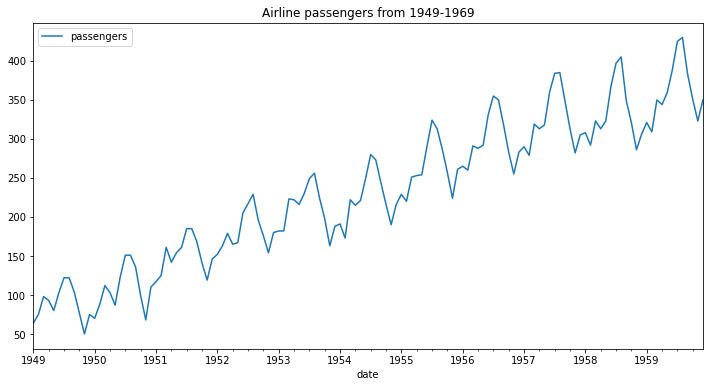

In [9]:
df[['passengers']].plot(kind='line',title='Airline passengers from 1949-1969',figsize=(12,6))

<AxesSubplot:xlabel='passengers', ylabel='Count'>

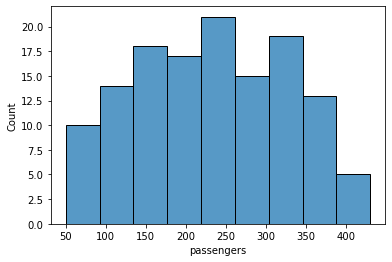

In [10]:
#distribution
sns.histplot(data=df, x='passengers')

### stripped heatmap

In [11]:
df_strip = pd.DataFrame(df.groupby(['year','month'])['passengers'].mean())
df_strip.head()

passengers
year month            
1949 1            64.0
     2            75.0
     3            98.0
     4            93.0
     5            80.0

In [12]:
df_strip = df_strip.reset_index()

In [13]:
df_pivot = df_strip.pivot('year','month', 'passengers')
df_pivot.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1949,64.0,75.0,98.0,93.0,80.0,103.0,122.0,122.0,104.0,77.0,50.0,75.0
1950,70.0,88.0,112.0,103.0,87.0,123.0,151.0,151.0,136.0,99.0,68.0,110.0
1951,117.0,125.0,161.0,142.0,154.0,161.0,185.0,185.0,168.0,141.0,119.0,146.0
1952,152.0,163.0,179.0,165.0,167.0,205.0,217.0,229.0,196.0,176.0,154.0,180.0
1953,182.0,182.0,223.0,222.0,216.0,230.0,249.0,256.0,224.0,198.0,163.0,188.0


Text(0.5, 1.0, 'MONTHLY COUNT OF AIRLINE PASSENGERS 1949 - 1969')

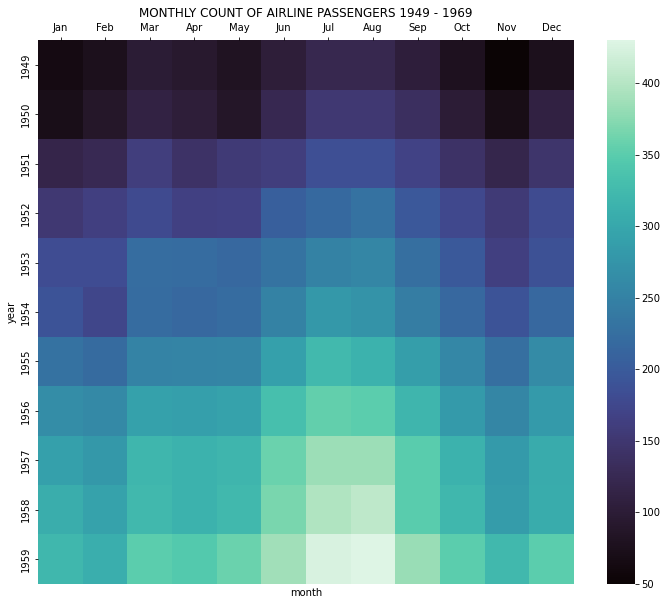

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(df_pivot, cbar=True,cmap='mako')

ax.xaxis.tick_top()
xticks_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(12) + .5, labels=xticks_labels)

title = 'Monthly Count of Airline Passengers 1949 - 1969'.upper()
plt.title(title, loc='center')

Conclusion
- we see a rise in airline passengers over the years for all months
- especially we see a rise for the summer holiday season since 1957 
- data is probabily not stationary, trend and seasonality

## Stationarizing timeseries

For forecasting a timeseries needs to be stationary. The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine if the series is stationary or not. The null hypothesis is that the time series is not stationary and is affected by trends.

In [17]:
#applying Augmented Dickey-Fuller Test
ADF = adfuller(df['passengers'], autolag='AIC')
print(f'ADF Statistic: {round(ADF[0],2)}')
print(f'p-value: {round(ADF[1],2)}')
for key, value in ADF[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')

ADF Statistic: -0.95
p-value: 0.77
Critial Values:
   1%, -3.49
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58


The p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. This makes the data non-stationary. To get a stationary series, we need to eliminate the trend and seasonality from the series.

First let's take a look at the componets of the timeseries.

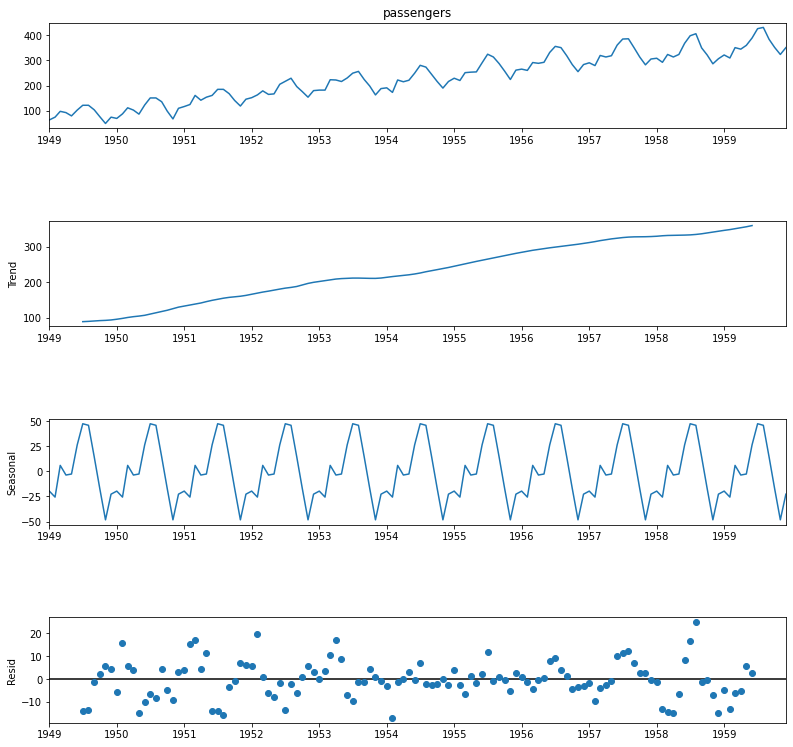

In [18]:
r = seasonal_decompose(df['passengers'], period=12)
f = r.plot()
f.set_figwidth(12)
f.set_figheight(12)

We see both an upwards trend and seasonalitiy in the data.

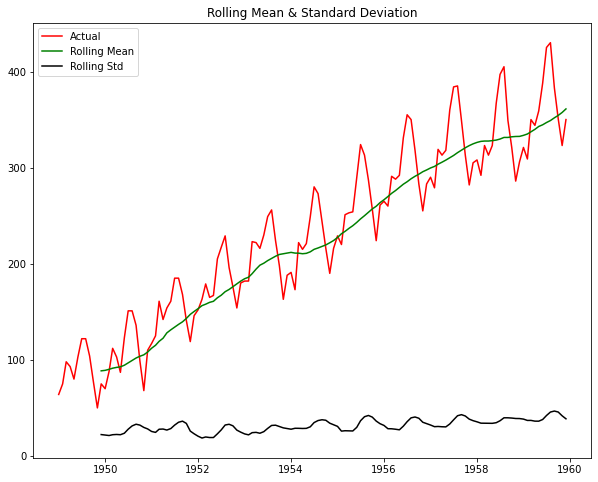

In [19]:
rolmean = df.passengers.rolling(window=12).mean()
rolstd=df.passengers.rolling(window=12).std()

plt.figure(figsize=(10,8))
actual=plt.plot(df.passengers, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False) 

## Get stationarity

There are a few ways to use transformation to make the data stationary:

- Moving average 
- Exponential smoothing 
- Shifting  
- Discomposing the residuals

To do: 

Compare the transformation using both the moving average (rolling mean) and exponential smoothing.

The rolling mean will take a window of "k" values and average them. 

The exponentially weighted mean uses "exponential decay" which decreases the weight of the previous means over time.

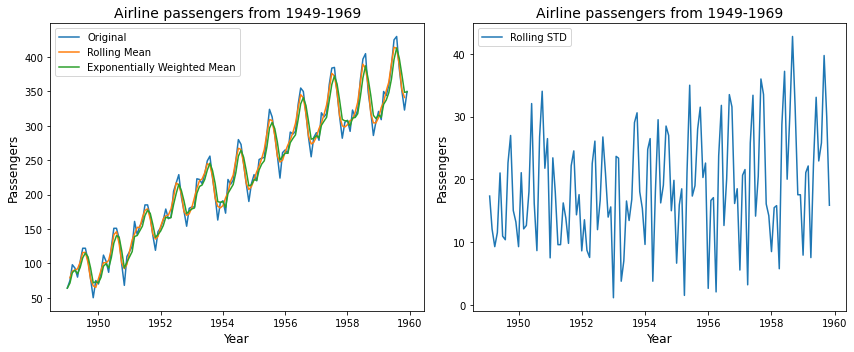

In [20]:
# Rolling mean 
temp_rol_mean = df.passengers.rolling(window=3, center=True).mean()

# Exponentially weighted mean 
temp_ewm = df.passengers.ewm(span=3).mean()

# Rolling standard deviation 
temp_rol_std = df.passengers.rolling(window=3, center=True).std()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Temperature graph with rolling mean and exponentially weighted mean
ax1.plot(df.passengers,label='Original')
ax1.plot(temp_rol_mean,label='Rolling Mean')
ax1.plot(temp_ewm, label='Exponentially Weighted Mean')
ax1.set_title('Airline passengers from 1949-1969',fontsize=14)
ax1.set_ylabel('Passengers',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Temperature graph with rolling STD 
ax2.plot(temp_rol_std,label='Rolling STD')
ax2.set_title('Airline passengers from 1949-1969',fontsize=14)
ax2.set_ylabel('Passengers',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

In [21]:
# Dickey-Fuller test 
temp_rol_mean.dropna(inplace=True)
temp_ewm.dropna(inplace=True)

In [22]:
print ('Dickey-Fuller Test for the Rolling Mean:')
#applying Augmented Dickey-Fuller Test
ADF = adfuller(temp_rol_mean, autolag='AIC')
print(f'ADF Statistic: {round(ADF[0],2)}')
print(f'p-value: {round(ADF[1],2)}')
for key, value in ADF[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')
print ('')
print ('Dickey-Fuller Test for the Exponentially Weighted Mean:')
ADF = adfuller(temp_ewm, autolag='AIC')
print(f'ADF Statistic: {round(ADF[0],2)}')
print(f'p-value: {round(ADF[1],2)}')
for key, value in ADF[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')

Dickey-Fuller Test for the Rolling Mean:
ADF Statistic: -1.11
p-value: 0.71
Critial Values:
   1%, -3.49
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58

Dickey-Fuller Test for the Exponentially Weighted Mean:
ADF Statistic: -1.07
p-value: 0.73
Critial Values:
   1%, -3.49
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58


Here both test statistics are greater than the critical values, so we have failed to reject the null hypothesis.

We can use differencing to remove the moving average or exponentially weighted mean from the original time series.

In [23]:
# Difference between the original and the rolling mean 
diff_rol_mean = df.passengers - temp_rol_mean
diff_rol_mean.dropna(inplace=True)
diff_rol_mean.head()


date
1949-02-01    -4.000000
1949-03-01     9.333333
1949-04-01     2.666667
1949-05-01   -12.000000
1949-06-01     1.333333
Name: passengers, dtype: float64

In [24]:
# Difference between the original and the exponentially weighted mean
diff_ewm = df.passengers - temp_ewm
diff_ewm.dropna(inplace=True)
diff_ewm.head()

date
1949-01-01     0.000000
1949-02-01     3.666667
1949-03-01    11.428571
1949-04-01     3.000000
1949-05-01    -4.838710
Name: passengers, dtype: float64

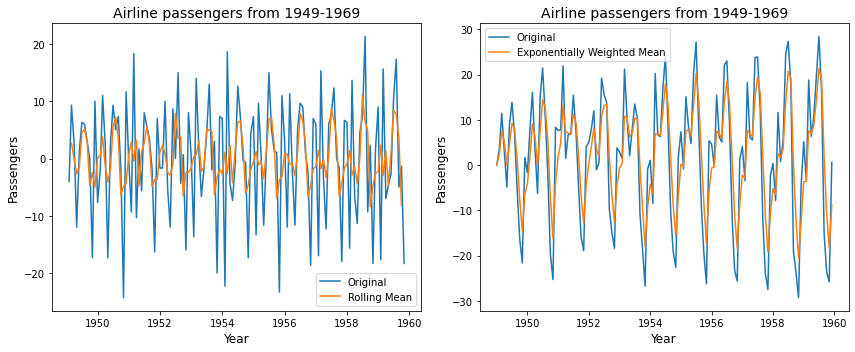

In [26]:
# Rolling mean of the difference
temp_rol_mean_diff = diff_rol_mean.rolling(window=3, center=True).mean()

# Expotentially weighted mean of the difference
temp_ewm_diff = diff_ewm.ewm(span=3).mean()

# Creating subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Difference graph with the rolling mean
ax1.plot(diff_rol_mean,label='Original')
ax1.plot(temp_rol_mean_diff,label='Rolling Mean')
ax1.set_title('Airline passengers from 1949-1969',fontsize=14)
ax1.set_ylabel('Passengers',fontsize=12)
ax1.set_xlabel('Year',fontsize=12)
ax1.legend()

# Difference graph with the exponentially weighted mean
ax2.plot(diff_ewm,label='Original')
ax2.plot(temp_ewm_diff,label='Exponentially Weighted Mean')
ax2.set_title('Airline passengers from 1949-1969',fontsize=14)
ax2.set_ylabel('Passengers',fontsize=12)
ax2.set_xlabel('Year',fontsize=12)
ax2.legend()

plt.tight_layout()

In [27]:
# Dickey-Fuller test 
print ('Dickey-Fuller Test for the Difference between the Original and Rolling Mean:')
ADF = adfuller(diff_rol_mean, autolag='AIC')
print(f'ADF Statistic: {round(ADF[0],2)}')
print(f'p-value: {round(ADF[1],2)}')
for key, value in ADF[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')
print ('')
print ('Dickey-Fuller Test for the Difference between the Original and Exponentially Weighted Mean:')
ADF = adfuller(diff_ewm, autolag='AIC')
print(f'ADF Statistic: {round(ADF[0],2)}')
print(f'p-value: {round(ADF[1],2)}')
for key, value in ADF[4].items():
    print('Critial Values:')
    print(f'   {key}, {round(value,2)}')

Dickey-Fuller Test for the Difference between the Original and Rolling Mean:
ADF Statistic: -7.55
p-value: 0.0
Critial Values:
   1%, -3.49
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58

Dickey-Fuller Test for the Difference between the Original and Exponentially Weighted Mean:
ADF Statistic: -2.93
p-value: 0.04
Critial Values:
   1%, -3.49
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58


The test statistic is less than the critial value, especially for the rolling mean, indicating that we can reject the null hypothesis. The data is stationary.

### Check residuals

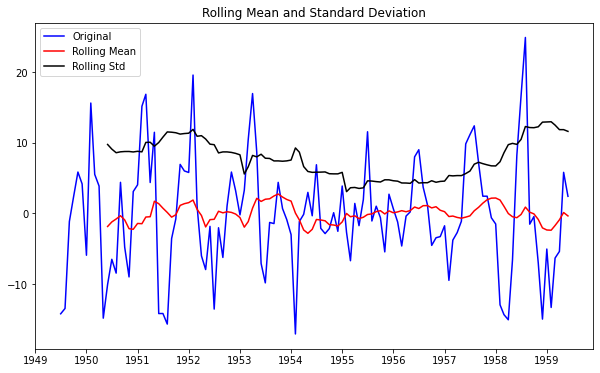

In [28]:
residual = r.resid
residual.dropna(inplace=True)


#Determing rolling statistics
rolmean = residual.rolling(12).mean()
rolstd = residual.rolling(12).std()
#Plot rolling statistics:
plt.figure(figsize=(10,6))
plt.plot(residual, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

After the decomposition the residuals have a nearly flat line for both mean and standard deviation. The timeseries is stationary and we can find the best parameters for the model.

## Find model parameters

Before we go on to build our forecasting model, we need to determine the best parameters by lookibg at the ACF and PACF plots.

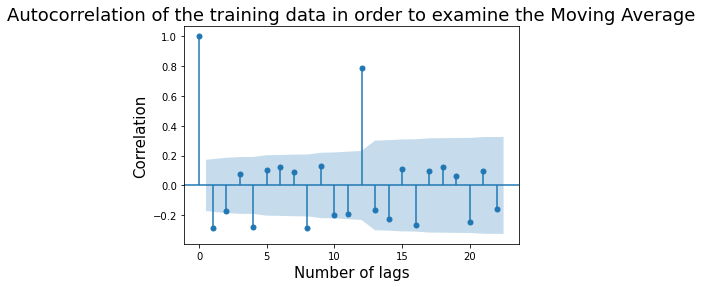

In [106]:
#plotting the number of lags - autocorrelation 
# we use d value here(diff_rol_mean)

plot_acf(diff_rol_mean);
plt.xlabel('Number of lags', size=15)
plt.ylabel('Correlation', size=15)
plt.title('Autocorrelation of the training data in order to examine the Moving Average', size=18);

/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


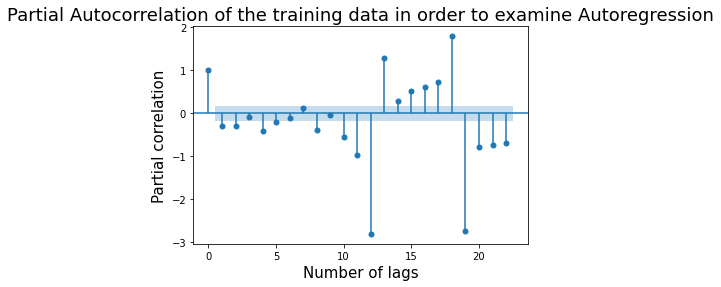

In [107]:
#plotting the number of lags - partial autocorrelation
plot_pacf(diff_rol_mean)
plt.xlabel('Number of lags', size=15)
plt.ylabel('Partial correlation', size=15)
plt.title('Partial Autocorrelation of the training data in order to examine Autoregression', size=18);

/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function')

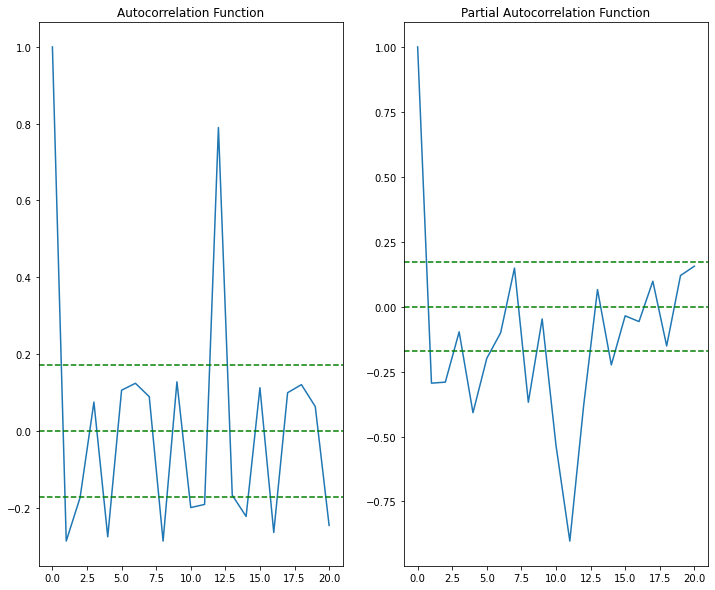

In [108]:
# we use d value here(diff_rol_mean)

acf=acf(diff_rol_mean, nlags=20)
pacf=pacf(diff_rol_mean, nlags=20, method='ols')

plt.figure(figsize=(12,10))

plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(diff_rol_mean)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(diff_rol_mean)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(diff_rol_mean)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(diff_rol_mean)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

In this plot, the two lines on either sides of 0 are the confidence interevals and can be used to determine the ‘p’ and ‘q’ values as:
- p – The lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time.

## Fit the model

/Users/valerie/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


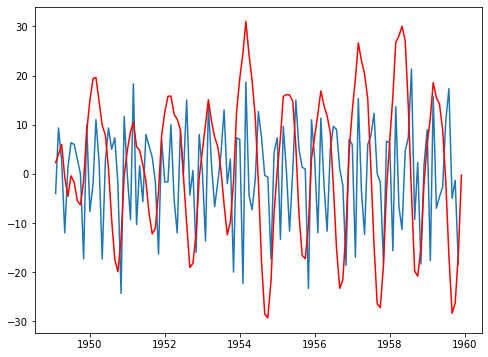

In [109]:
model = ARIMA(df.passengers, order=(2, 1, 2), freq=df.index.inferred_freq)  
results = model.fit(disp=0) 
plt.figure(figsize=(8,6)) 
plt.plot(diff_rol_mean)
plt.plot(results.fittedvalues, color='red')
plt.show()


## Make predictions

Forecast for the next years

In [110]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

date
1949-02-01    2.291626
1949-03-01    3.921880
1949-04-01    5.979584
1949-05-01   -0.687769
1949-06-01   -4.578149
dtype: float64


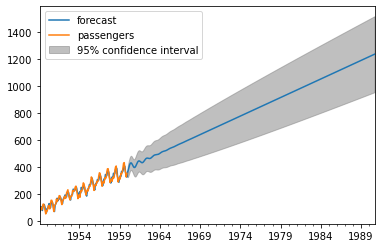

In [111]:
results.plot_predict(1,500)
x=results.forecast(steps=120)

From the above graph, we calculated the future predictions till 1990. The greyed out area is the confidence interval, which means the predictions will not cross that area.

Next step:

Use SARIMA model on the data to take into account seasonality